### Eriks dubbelkoll

Jag tänker att jag skriver simuleringar där jag dubbelkollar det vi skriver i rapporten.

### Imports

In [1]:
import ROOT
import time
import math
import numpy as np

Welcome to JupyROOT 6.22/02


In [2]:
def set_title(plot, title, x_label, y_label, z_label):
    plot.SetTitle(title)
    ROOT.gPad.Update()
    
    plot.GetXaxis().SetTitle(x_label)
    plot.GetXaxis().SetLabelSize(0.025)
    plot.GetXaxis().SetTitleSize(0.025)
    plot.GetXaxis().SetTitleOffset(2)
    
    plot.GetYaxis().SetTitle(y_label)
    plot.GetYaxis().SetLabelSize(0.025)
    plot.GetYaxis().SetTitleSize(0.025)
    plot.GetYaxis().SetTitleOffset(2)
    
    plot.GetZaxis().SetTitle(z_label)
    plot.GetZaxis().SetLabelSize(0.025)
    plot.GetZaxis().SetTitleSize(0.025)
    plot.GetZaxis().SetTitleOffset(1.8)

### Class definitions

In [21]:
class noise_generator:
    def __init__(self, threshold, channel_count):
        noise = ROOT.TF1("noise_gauss", "TMath::Gaus(x, 0, 5)", 0, 1000)
        self._mean = channel_count * noise.Integral(threshold, 1000)/noise.Integral(0, 1000)/2
        self._prng = ROOT.TRandom3(time.time_ns())

    def generate(self):
        total = self._prng.Poisson(self._mean)
        narrow = 0
        for i in range(total):
            if self._prng.Uniform(25) < 3.125:
                narrow += 1
        estimate = 3.125 * (total - narrow)/(25 - 3.125)
        return narrow, estimate

    
class particles_generator:
    def __init__(self, threshold, expected_voltage):
        self._threshold = threshold
        self._expected_voltage = expected_voltage
        signal_func = ROOT.TF1("sth", "TMath::Landau(x, %f, %f)" % (expected_voltage, expected_voltage/4), -100, 1000)
        self.fraction_above = signal_func.Integral(threshold, 1000)/signal_func.Integral(-100, 1000)
        self._prng = ROOT.TRandom3(time.time_ns())
    
    def generate(self, expected_count):
        signal_count = self._prng.Poisson(expected_count)
        above_threshold_count = 0
        for i in range(signal_count):
            if self._prng.Landau(self._expected_voltage, self._expected_voltage/4) > self._threshold:
                above_threshold_count += 1
        return signal_count, above_threshold_count
    
class simulation:
    def __init__(self, threshold, expected_voltage, expected_count, bunch_crossing_count):
        self._threshold = threshold
        self._expected_voltage = expected_voltage
        self._expected_count = expected_count
        self._bunch_crossing_count = bunch_crossing_count
        
        channel_count = int(3.6*10**6)
        self._particles = particles_generator(threshold, expected_voltage)
        self._noise = noise_generator(threshold, channel_count)
    
    def run(self):
        actual_particles_sum = 0
        noise_subtracted_activations_sum = 0

        for i in range(self._bunch_crossing_count):
            noise_exact, noise_est = self._noise.generate()
            particles_total, particles_above = self._particles.generate(self._expected_count)
            actual_particles_sum += particles_total
            noise_subtracted_activations_sum += particles_above + noise_exact - noise_est

        return actual_particles_sum, noise_subtracted_activations_sum
    
    def run_with_model_errors(self, errors):
        actual_particles, noise_subtracted_activations_sum = self.run()
        relative_errors = []
        
        for error1 in errors:
            model_expected_voltage = self._expected_voltage + error1
            signal_func = ROOT.TF1("sth", "TMath::Landau(x, %f, %f)" % (model_expected_voltage, model_expected_voltage/4), -100, 1000)
            fraction_above = signal_func.Integral(self._threshold, 1000)/signal_func.Integral(-100, 1000)
            particle_est = noise_subtracted_activations_sum/fraction_above
            
            #relative_errors.append(math.log(abs(1 - particle_est/actual_particles)))
            relative_errors.append(abs(1 - particle_est/actual_particles))
    
        return relative_errors
            

### Simulations

In [4]:
my_sim = simulation(2, 100, 22.5, 1)
print(my_sim.run())

(19, -302.0)


### Fix peak voltage

In [136]:
collisions_per_bc = 200
particles_per_collision = 75
ratio_of_particles_reaching_hgtd = 0.1
average_particle_count = collisions_per_bc * particles_per_collision * ratio_of_particles_reaching_hgtd


t = time.time()
thresholds = np.linspace(20, 50, 40)
model_peak_voltage_errors = np.linspace(-20, 20, 40)

canvas = ROOT.TCanvas("canvas 1", "canvas 1", 1000, 800)
ROOT.gStyle.SetTitleFontSize(0.035)
ROOT.gStyle.SetTitleOffset(1)

plot = ROOT.TGraph2D()
hist = ROOT.TH2F("hcont1","Option CONT1Z example ",40 ,20 ,50 ,40 ,-20, 20);
point_index = 0

for threshold in thresholds:
    my_sim = simulation(threshold, 100, average_particle_count, 10000)
    relative_errors = my_sim.run_with_model_errors(model_peak_voltage_errors)
    for i, error1 in enumerate(model_peak_voltage_errors):
        err = math.log(relative_errors[i])
        plot.SetPoint(point_index, threshold, error1, err)
        hist.Fill(threshold, error1, err)
        point_index += 1

t = time.time() - t

print("Simulation took " + str(t) + " seconds")        

Simulation took 677.8988053798676 seconds


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas 1
Warning in <TROOT::Append>: Replacing existing TH1: hcont1 (Potential memory leak).


### Fix threshold

In [67]:
collisions_per_bc = 10.0
particles_per_collision = 75
ratio_of_particles_reaching_hgtd = 0.1
average_particle_count = collisions_per_bc * particles_per_collision * ratio_of_particles_reaching_hgtd


t = time.time()
thresholds = np.linspace(20, 50, 40)
model_peak_voltage_errors = np.linspace(-20, 20, 40)

canvas = ROOT.TCanvas("canvas 1", "canvas 1", 1000, 800)
ROOT.gStyle.SetTitleFontSize(0.035)
ROOT.gStyle.SetTitleOffset(1)

plot = ROOT.TGraph2D()
hist = ROOT.TH2F("hcont1","Option CONT1Z example ",40 ,20 ,50 ,40 ,-20, 20);
point_index = 0

for threshold in thresholds:
    my_sim = simulation(threshold, 100, average_particle_count, 100000)
    relative_errors = my_sim.run_with_model_errors(model_peak_voltage_errors)
    for i, error1 in enumerate(model_peak_voltage_errors):
        plot.SetPoint(point_index, threshold, error1, relative_errors[i])
        hist.Fill(threshold, error1, relative_errors[i])
        point_index += 1

t = time.time() - t

print("Simulation took " + str(t) + " seconds")   

Simulation took 371.17501187324524 seconds


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas 1
Warning in <TROOT::Append>: Replacing existing TH1: hcont1 (Potential memory leak).


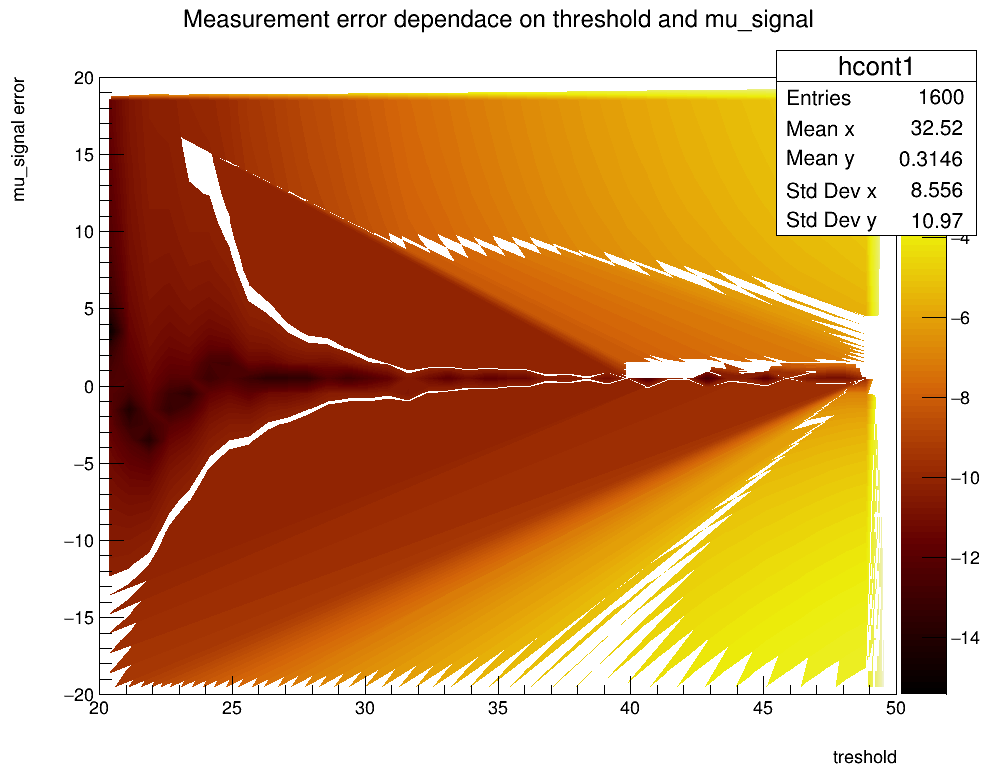

In [149]:
hist.Draw("CONT0Z")
ROOT.gStyle.SetNumberContours(255)
#ROOT.gStyle.SetPalette(1)
set_title(hist, "Measurement error dependace on threshold and mu_signal", "treshold", "mu_signal error", "logarithmic error")

canvas.Draw()

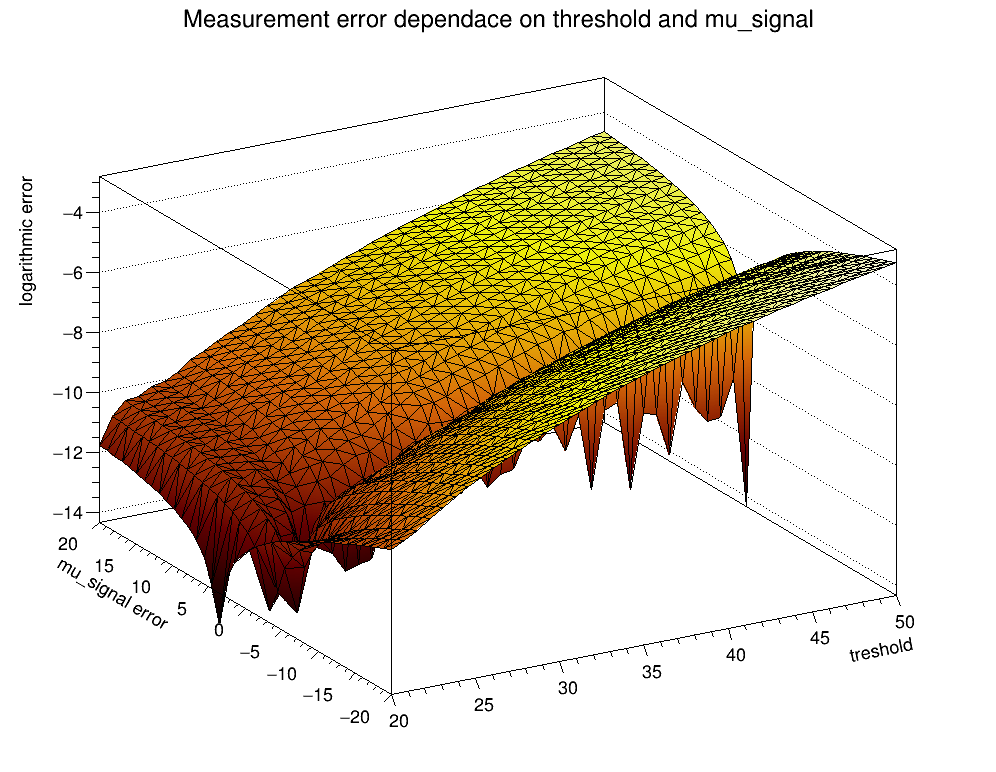

In [139]:
plot.Draw("TRI1")
ROOT.gStyle.SetPalette(53)
set_title(plot, "Measurement error dependace on threshold and mu_signal", "treshold", "mu_signal error", "logarithmic error")
canvas.Draw()

### Kommentarer på resultat
Som väntat går relativa felet mot noll då antalet bunch crossings ökar. Är det vi håller på med ens meningsfullt då?